In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
print(train_data.shape)
print(test_data.shape)

(404, 13)
(102, 13)


In [4]:
print(train_data[0])

[  1.23247   0.        8.14      0.        0.538     6.142    91.7
   3.9769    4.      307.       21.      396.9      18.72   ]


In [5]:
print(train_targets)

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4 12.1 17.9 23.1 19.9
 15.7  8.8 50.  22.5 24.1 27.5 10.9 30.8 32.9 24.  18.5 13.3 22.9 34.7
 16.6 17.5 22.3 16.1 14.9 23.1 34.9 25.  13.9 13.1 20.4 20.  15.2 24.7
 22.2 16.7 12.7 15.6 18.4 21.  30.1 15.1 18.7  9.6 31.5 24.8 19.1 22.
 14.5 11.  32.  29.4 20.3 24.4 14.6 19.5 14.1 14.3 15.6 10.5  6.3 19.3
 19.3 13.4 36.4 17.8 13.5 16.5  8.3 14.3 16.  13.4 28.6 43.5 20.2 22.
 23.  20.7 12.5 48.5 14.6 13.4 23.7 50.  21.7 39.8 38.7 22.2 34.9 22.5
 31.1 28.7 46.  41.7 21.  26.6 15.  24.4 13.3 21.2 11.7 21.7 19.4 50.
 22.8 19.7 24.7 36.2 14.2 18.9 18.3 20.6 24.6 18.2  8.7 44.  10.4 13.2
 21.2 37.  30.7 22.9 20.  19.3 31.7 32.  23.1 18.8 10.9 50.  19.6  5.
 14.4 19.8 13.8 19.6 23.9 24.5 25.  19.9 17.2 24.6 13.5 26.6 21.4 11.9
 22.6 19.6  8.5 23.7 23.1 22.4 20.5 23.6 18.4 35.2 23.1 27.9 20.6 23.7
 28.  13.6 27.1 23.6 20.6 18.2 21.7 17.1  8.4 25.3 13.8 22.2 18.4 20.7
 31.6 30.5 20.3  8.8 19.2 19.4 23.1 23.  14.8 48.8 22.6 33.4 21.1 13.6
 32.2 13.1

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std

# test data를 정규화 할 때도 test set를 사용하면 안된다!
test_data -= mean
test_data /= std

In [7]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## K-fold cross-vaildation을 사용한 훈련 검증🧨
<br/>
샘플이 적은 경우, 이전과 같이 데이터를 훈련 셋과 검증 셋으로 나누기 부담스럽다.
<p>
이런 상황에 가장 좋은 방법은 k-fold cross-vaildation을 사용하는 것이다.<br/>
쉽게 데이터를 K개로 분할해 K개의 모델을 각각 만들어 K-1의 분할을 해서 평가하는 방법이다.<br/>
검증 점수는 K개의 검증 점수 평균이 된다.</p>

In [8]:
import numpy as np

k = 4
num_val_samples = len(train_data)//k
num_epochs = 100
all_score = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i*num_val_samples: (i+1) * num_val_samples]
    val_target = train_targets[i*num_val_samples: (i+1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples],
        train_data[(i+1)*num_val_samples:]],
        axis=0
    )
    partial_train_target = np.concatenate(
        [train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]],
        axis=0
    )

    model = build_model()
    model.fit(partial_train_data, partial_train_target, epochs=num_epochs, batch_size=1, verbose=1)
    val_mse, val_mae = model.evaluate(val_data, val_target, verbose=1)
    all_score.append(val_mse)

처리중인 폴드 # 0
Epoch 1/100
303/303 [==============================] - 3s 4ms/step - loss: 186.8548 - mae: 9.8847
Epoch 2/100
303/303 [==============================] - 1s 4ms/step - loss: 30.0981 - mae: 3.7045
Epoch 3/100
303/303 [==============================] - 1s 4ms/step - loss: 21.2488 - mae: 3.1045
Epoch 4/100
303/303 [==============================] - 1s 4ms/step - loss: 18.3443 - mae: 2.8357
Epoch 5/100
303/303 [==============================] - 1s 4ms/step - loss: 16.1326 - mae: 2.6675
Epoch 6/100
133/303 [============>.................] - ETA: 0s - loss: 18.3801 - mae: 2.8556

KeyboardInterrupt: 

In [ ]:
all_score

[10.11679458618164]

In [ ]:
print(all_score)

[10.11679458618164]


In [11]:
num_epochs = 500
all_score = []
all_mae_histories = []
for i in range(k):
    print('처리중인 폴드 #', i)
    val_data = train_data[i*num_val_samples: (i+1) * num_val_samples]
    val_target = train_targets[i*num_val_samples: (i+1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i*num_val_samples],
        train_data[(i+1)*num_val_samples:]],
        axis=0
    )
    partial_train_target = np.concatenate(
        [train_targets[:i*num_val_samples],
        train_targets[(i+1)*num_val_samples:]],
        axis=0
    )

    model = build_model()
    history = model.fit(partial_train_data, partial_train_target, 
                        validation_data=(val_data, val_target),
                        epochs=num_epochs, batch_size=1, verbose=1)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
Epoch 1/500
303/303 [==============================] - 2s 5ms/step - loss: 215.4714 - mae: 10.8114 - val_loss: 36.7548 - val_mae: 3.8192
Epoch 2/500
303/303 [==============================] - 1s 5ms/step - loss: 28.9574 - mae: 3.7312 - val_loss: 24.4985 - val_mae: 3.0738
Epoch 3/500
303/303 [==============================] - 1s 5ms/step - loss: 21.4329 - mae: 3.1778 - val_loss: 20.2181 - val_mae: 2.9417
Epoch 4/500
303/303 [==============================] - 1s 4ms/step - loss: 18.4483 - mae: 2.9184 - val_loss: 16.2014 - val_mae: 2.8429
Epoch 5/500
303/303 [==============================] - 1s 4ms/step - loss: 16.5242 - mae: 2.6924 - val_loss: 14.3983 - val_mae: 2.5762
Epoch 6/500
303/303 [==============================] - 1s 4ms/step - loss: 15.0238 - mae: 2.6227 - val_loss: 15.3554 - val_mae: 2.4780
Epoch 7/500
303/303 [==============================] - 1s 4ms/step - loss: 14.8881 - mae: 2.5249 - val_loss: 12.6540 - val_mae: 2.4638
Epoch 8/500
303/303 [====================

In [12]:
print(all_mae_histories)

[[3.8192455768585205, 3.0738487243652344, 2.941730260848999, 2.8428783416748047, 2.5761585235595703, 2.4779860973358154, 2.4637527465820312, 2.2059547901153564, 2.628269672393799, 2.146960973739624, 2.1811230182647705, 2.3848989009857178, 2.299180030822754, 2.041036367416382, 2.051112651824951, 1.9166673421859741, 2.330242395401001, 2.267679452896118, 2.2161896228790283, 2.0545995235443115, 1.9162322282791138, 2.1698732376098633, 1.9537924528121948, 2.3055500984191895, 1.9612298011779785, 2.070993661880493, 2.165306806564331, 2.1306045055389404, 2.0996830463409424, 1.8428508043289185, 1.9831318855285645, 1.8160858154296875, 1.927397608757019, 1.886823296546936, 2.138479471206665, 1.8316985368728638, 2.0233869552612305, 1.858312726020813, 1.8488798141479492, 2.0682268142700195, 1.8551747798919678, 2.112071990966797, 1.8329728841781616, 1.8230544328689575, 2.194166421890259, 1.7276949882507324, 1.8855109214782715, 1.9214179515838623, 1.9372185468673706, 2.791896104812622, 1.8619449138641

In [13]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)
]
print(average_mae_history)

[4.5738332867622375, 3.5304654836654663, 3.1007962822914124, 3.0408599376678467, 2.8065736293792725, 2.806755483150482, 2.7673723697662354, 2.6741902828216553, 2.7489014863967896, 2.528330624103546, 2.7477554082870483, 2.8474024534225464, 2.5892328023910522, 2.492855191230774, 2.4650826454162598, 2.4241211116313934, 2.5559083819389343, 2.494534194469452, 2.548249661922455, 2.5446172952651978, 2.3966470062732697, 2.544240355491638, 2.368202656507492, 2.469766914844513, 2.4496673345565796, 2.4438552856445312, 2.5102756023406982, 2.429435431957245, 2.459905505180359, 2.3275084793567657, 2.467206835746765, 2.2800182700157166, 2.314436048269272, 2.588799148797989, 2.383196771144867, 2.285206824541092, 2.5914554595947266, 2.274484008550644, 2.3242428302764893, 2.4019444584846497, 2.2112128734588623, 2.285104513168335, 2.289440840482712, 2.505196660757065, 2.4302257895469666, 2.3623119592666626, 2.4227065443992615, 2.333368957042694, 2.4599145352840424, 2.4928327202796936, 2.2607624530792236,

In [16]:
print(np.shape(all_mae_histories), np.shape(average_mae_history))

(4, 500) (500,)


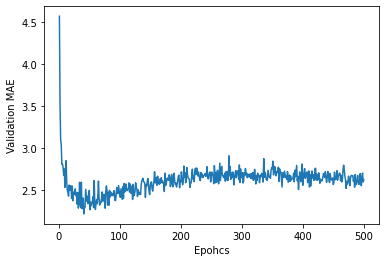

In [17]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) +1), average_mae_history)
plt.xlabel('Epohcs'); plt.ylabel('Validation MAE')
plt.show()

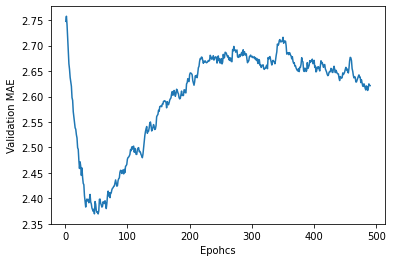

In [19]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history) +1), smooth_mae_history)
plt.xlabel('Epohcs'); plt.ylabel('Validation MAE')
plt.show()

In [20]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)

test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 18.6292 - mae: 2.6799


In [21]:
test_mse_score

18.629194259643555

In [22]:
test_mae_score

2.6798694133758545